チームわらわら　機械分析

In [81]:
# pip install missingno

In [82]:
import  pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.mixture import BayesianGaussianMixture
from pandas.plotting import parallel_coordinates
import missingno as msno

In [83]:
# CSVの読み込み
df = pd.read_csv("wwww_db.csv")

ピボット処理を行い、reception_idごとに1行にまとめるワイドフォーマットへの変換

In [84]:
df_wide_format = df.pivot_table(index="reception_id",
                                columns="question_id",
                                values=["answer_numeric", "answer_boolean", "answer_categorical"],
                                aggfunc="first")
# カラム名を整理（例: "q1_answer_numeric", "q2_answer_boolean" など）
df_wide_format.columns = [f"q{col[1]}_{col[0]}" for col in df_wide_format.columns]
df_wide_format.reset_index(inplace=True)

print(df_wide_format.head())


   reception_id  q2_answer_boolean  q3_answer_boolean  q5_answer_boolean  \
0          1000                0.0                1.0                1.0   
1          1001                0.0                0.0                1.0   
2          1002                0.0                1.0                1.0   
3          1003                1.0                1.0                1.0   
4          1004                1.0                0.0                0.0   

   q6_answer_boolean q1_answer_categorical q4_answer_categorical  \
0                0.0               1R / 1K                 エリア設定   
1                0.0                3LDK以上                  どちらも   
2                0.0               1R / 1K                 エリア設定   
3                1.0             1LDK〜2LDK                  どちらも   
4                0.0               1R / 1K                  特になし   

   q7_answer_numeric  q8_answer_numeric  q9_answer_numeric  \
0                5.0                5.0                2.0   
1         

分かりやすいようにカラムをリネーム

In [85]:
rename_map = {
    "q1_answer_categorical":  "room_layout",            # (1) ロボット掃除機を使いたい部屋の間取りを教えてください。
    "q2_answer_boolean":      "pet_room",               # (2) ペットを飼っている部屋でロボット掃除機を使いたいですか？
    "q3_answer_boolean":      "carpet_rug",             # (3) お部屋にはカーペットやラグがありますか？
    "q4_answer_categorical":  "app_features",           # (4) ロボット掃除機のアプリで欲しい機能はどれですか？
    "q5_answer_boolean":      "wipe_cleaning",          # (5) 拭き掃除もロボット掃除機に任せたいですか？
    "q6_answer_boolean":      "auto_dustbin",           # (6) 自動ゴミ収集機能が欲しいですか？
    "q7_answer_numeric":      "quiet_mode",             # (7) 吸引力が落ちても静かに掃除して欲しい
    "q8_answer_numeric":      "less_collision",         # (8) 細かい場所の掃除制度は下がっても衝突回数が減る方がいい
    "q9_answer_numeric":      "fully_automated",        # (9) 掃除はロボット掃除機に全て任せたい
    "q10_answer_numeric":     "detailed_suction",       # (10) 部屋全体・部屋の隅・壁際などの細かい場所でもしっかり吸引してほしい？
    "q11_answer_numeric":     "finish_when_away",       # (11) 家にいる時に掃除してくれるよりも、外出中に掃除が終わっている方がいい
    "q12_answer_numeric":     "maintenance_reduction"   # (12) 多少高くてもメンテナンスの手間が減るほどいい
}

# 辞書を用いて列名を置き換え
df_renamed = df_wide_format.rename(columns=rename_map)

print(df_renamed.columns)

Index(['reception_id', 'pet_room', 'carpet_rug', 'wipe_cleaning',
       'auto_dustbin', 'room_layout', 'app_features', 'quiet_mode',
       'less_collision', 'fully_automated', 'detailed_suction',
       'finish_when_away', 'maintenance_reduction'],
      dtype='object')


In [86]:
# q1とq4はカテゴリカルなのでエンコーディング実施
df_encoded = df_renamed.copy()
# q1_answer_categorical（間取り情報）はラベルエンコーディング
le = LabelEncoder()
# 欠損値がある場合は、一旦文字列に変換して埋める（ここでは "missing" として扱う）
df_encoded["room_layout"] = df_encoded["room_layout"].fillna("missing")
df_encoded["room_layout"] = le.fit_transform(df_encoded["room_layout"])


# q4_answer_categorical はワンホットエンコーディング
df_encoded = pd.get_dummies(df_encoded, columns=["app_features"], prefix="app_features", dummy_na=True)
# ワンホットエンコーディングの結果がbooleanの場合、0/1の整数に変換
for col in df_encoded.columns:
    if col.startswith("app_features"):
        df_encoded[col] = df_encoded[col].astype(int)

print(df_encoded.head(5))

   reception_id  pet_room  carpet_rug  wipe_cleaning  auto_dustbin  \
0          1000       0.0         1.0            1.0           0.0   
1          1001       0.0         0.0            1.0           0.0   
2          1002       0.0         1.0            1.0           0.0   
3          1003       1.0         1.0            1.0           1.0   
4          1004       1.0         0.0            0.0           0.0   

   room_layout  quiet_mode  less_collision  fully_automated  detailed_suction  \
0            1         5.0             5.0              2.0               5.0   
1            2         5.0             1.0              2.0               4.0   
2            1         3.0             5.0              3.0               3.0   
3            0         1.0             3.0              1.0               3.0   
4            1         2.0             1.0              3.0               3.0   

   finish_when_away  maintenance_reduction  app_features_どちらも  \
0               4.0        

データの可視化を実行
単変量可視化

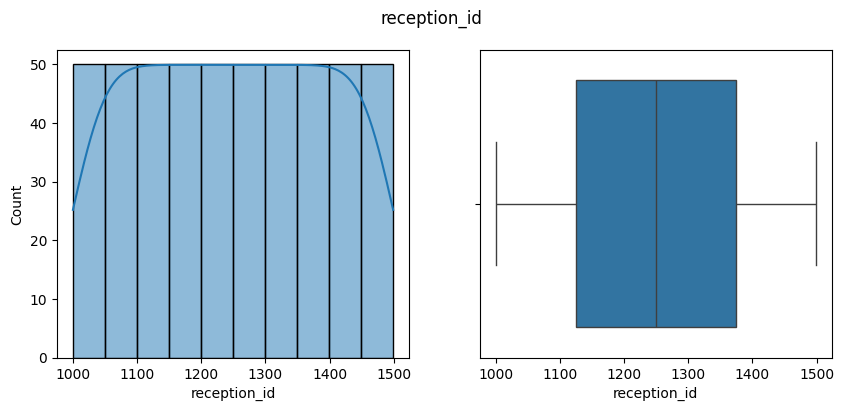

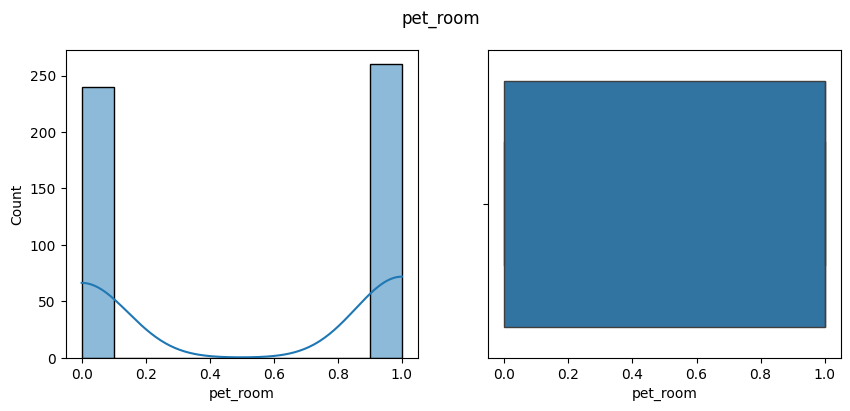

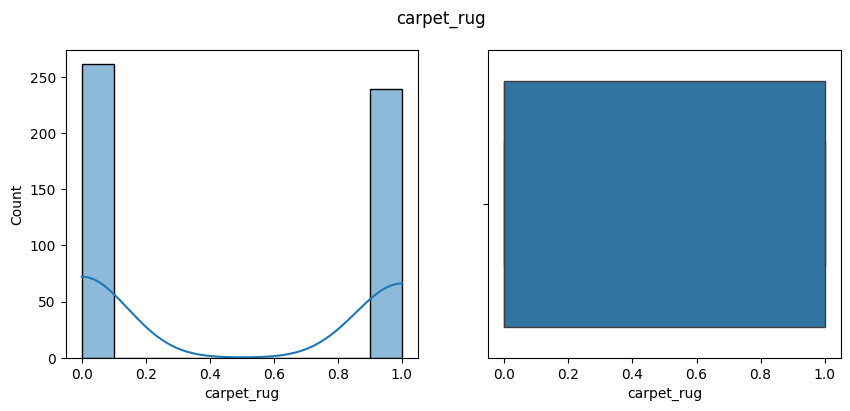

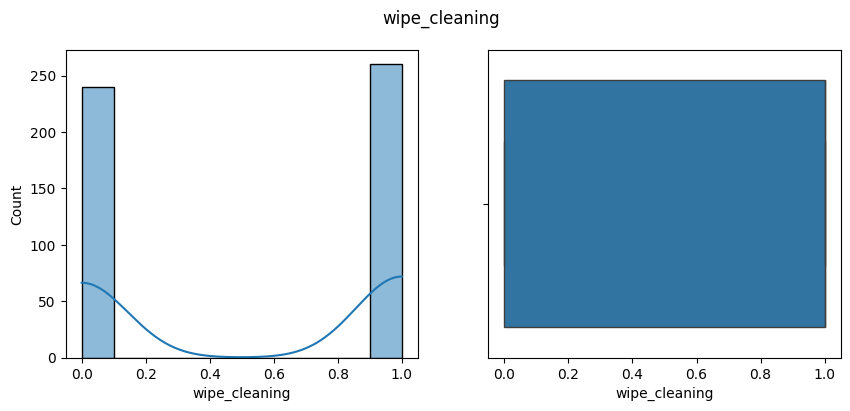

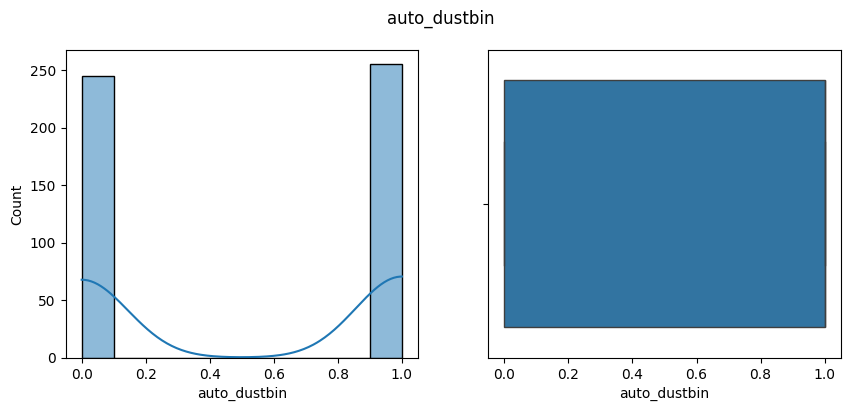

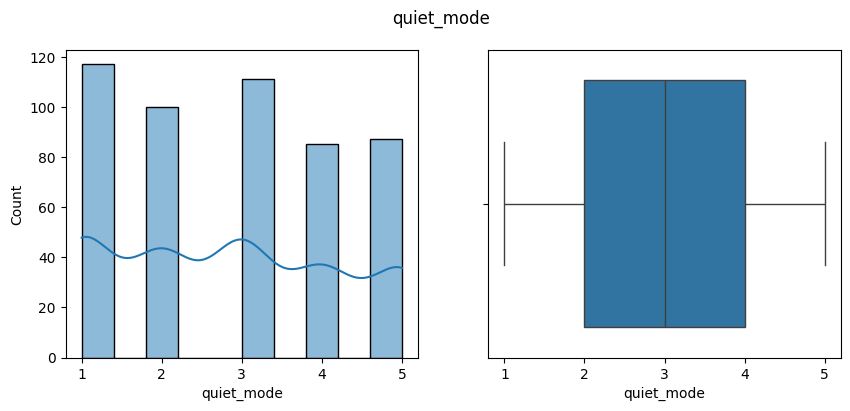

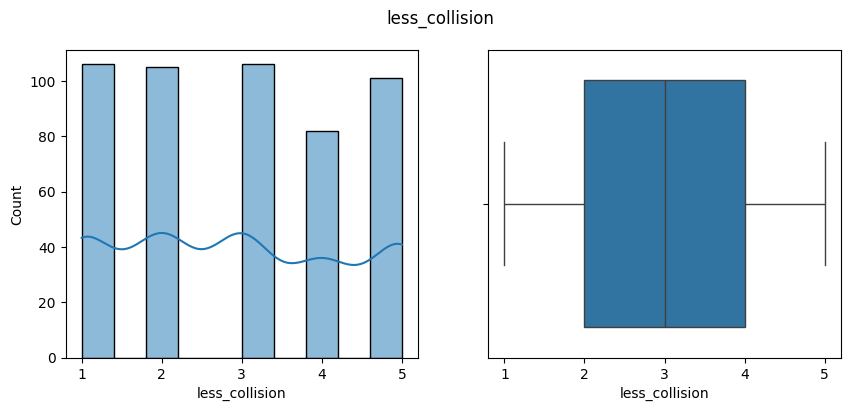

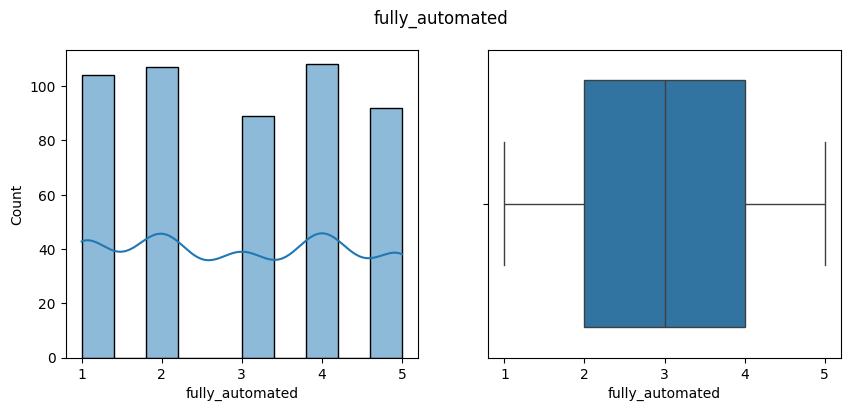

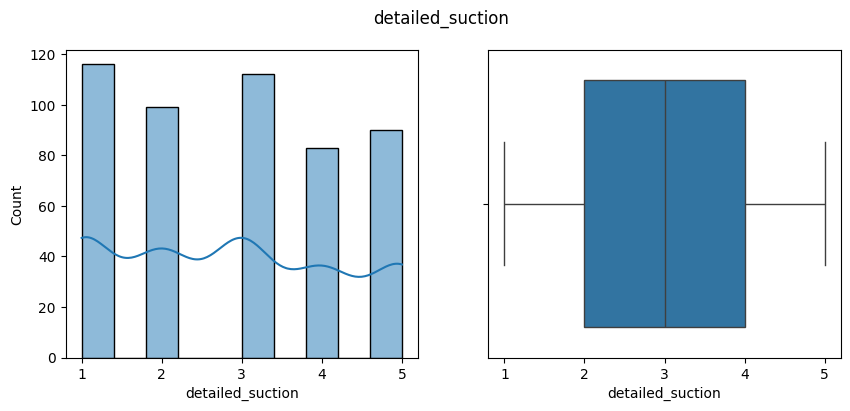

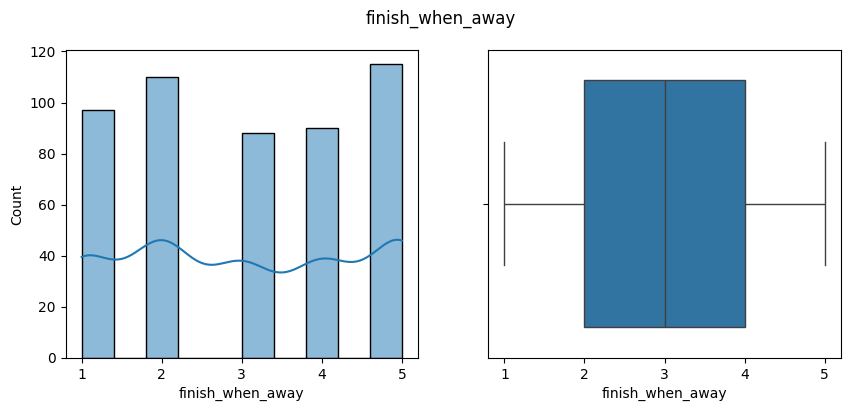

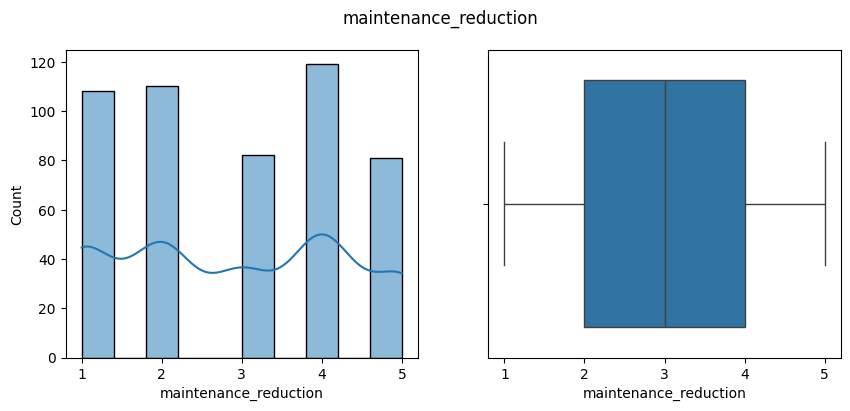

In [87]:
numeric_cols = df_encoded.select_dtypes(include=['int64','float64']).columns
for col in numeric_cols:
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    sns.histplot(df_encoded[col].dropna(), ax=axes[0], kde=True)
    sns.boxplot(x=df_encoded[col], ax=axes[1])
    plt.suptitle(col)
    plt.show()

二変量可視化（相関ヒートマップ）


c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 12393 (\N{HIRAGANA LETTER DO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 12385 (\N{HIRAGANA LETTER TI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 12425 (\N{HIRAGANA LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 12418 (\N{HIRAGANA LETTER MO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 12456 (\N{KATAKANA LETTER E}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\堀江雅彦\Ap

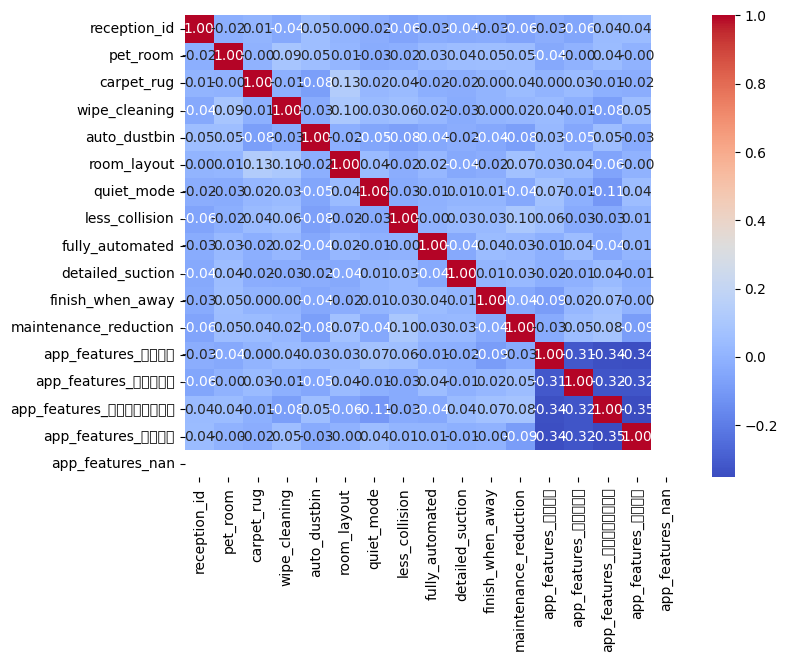

In [88]:
plt.figure(figsize=(8,6))
sns.heatmap(df_encoded.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

多変量可視化（PCA, t-SNE）
ワイドフォーマットのデータ（df_wide_format）から数値データだけを取り出し、欠損値のある行を除外した上で、PCAとt-SNEという次元削減手法を用いてデータを2次元に圧縮し、可視化

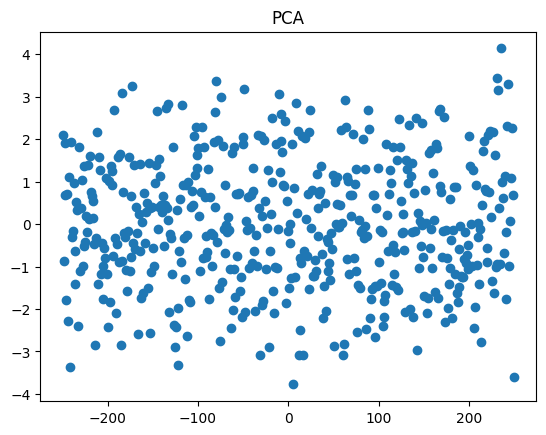

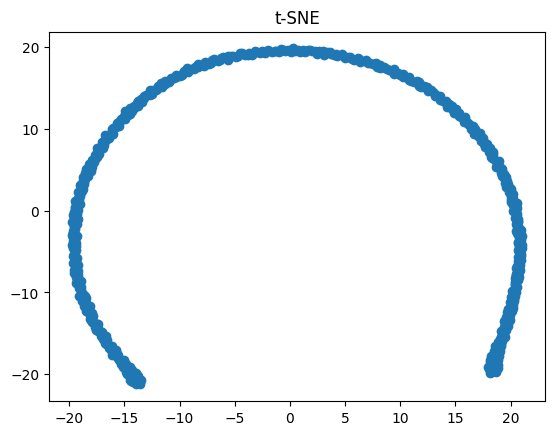

In [89]:
# 数値型のカラムだけを抽出
df_num = df_encoded.select_dtypes(include=['int64','float64']).dropna()

# PCA（主成分分析）を用いて、元の多次元データを2つの主成分に圧縮します。
# 得られた2次元のデータを散布図にプロットすることで、データ全体の大まかな構造や潜在的なクラスタが視覚的に確認できる
pca = PCA(n_components=2).fit_transform(df_num)
plt.scatter(pca[:,0], pca[:,1])
plt.title("PCA")
plt.show()

# t-SNE（t分布型確率的近傍埋め込み）は、局所的な構造をうまく保持する次元削減手法です。
# 同様に2次元に変換したデータを散布図にプロットし、細かなクラスタリングの兆候などを視覚的に把握
tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(df_num)
plt.scatter(tsne[:,0], tsne[:,1])
plt.title("t-SNE")
plt.show()

欠損可視化

In [90]:
# msno.matrix(df_encoded)
# plt.show()
# msno.heatmap(df_encoded)
# plt.show()

KMeansでクラスタリング

In [91]:
#  クラスタリング用に数値型のカラムだけを抽出（欠損値のある行は除外）
df_numeric = df_encoded.select_dtypes(include=['int64','float64']).dropna()

# reception_idを除外してクラスタリング用のDataFrameを作成
# reception_idが極端に大きな値のため除外
df_for_cluster = df_numeric.drop(columns=['reception_id'], errors='ignore')

#  KMeansでクラスタリング（例：クラスタ数3）
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_for_cluster)
df_for_cluster['cluster'] = clusters.astype(str)  # 色分けのため文字列に変換


ペアプロットの作成（KMeansのクラスタごとに色分け）適当にクラスタ数は3に設定

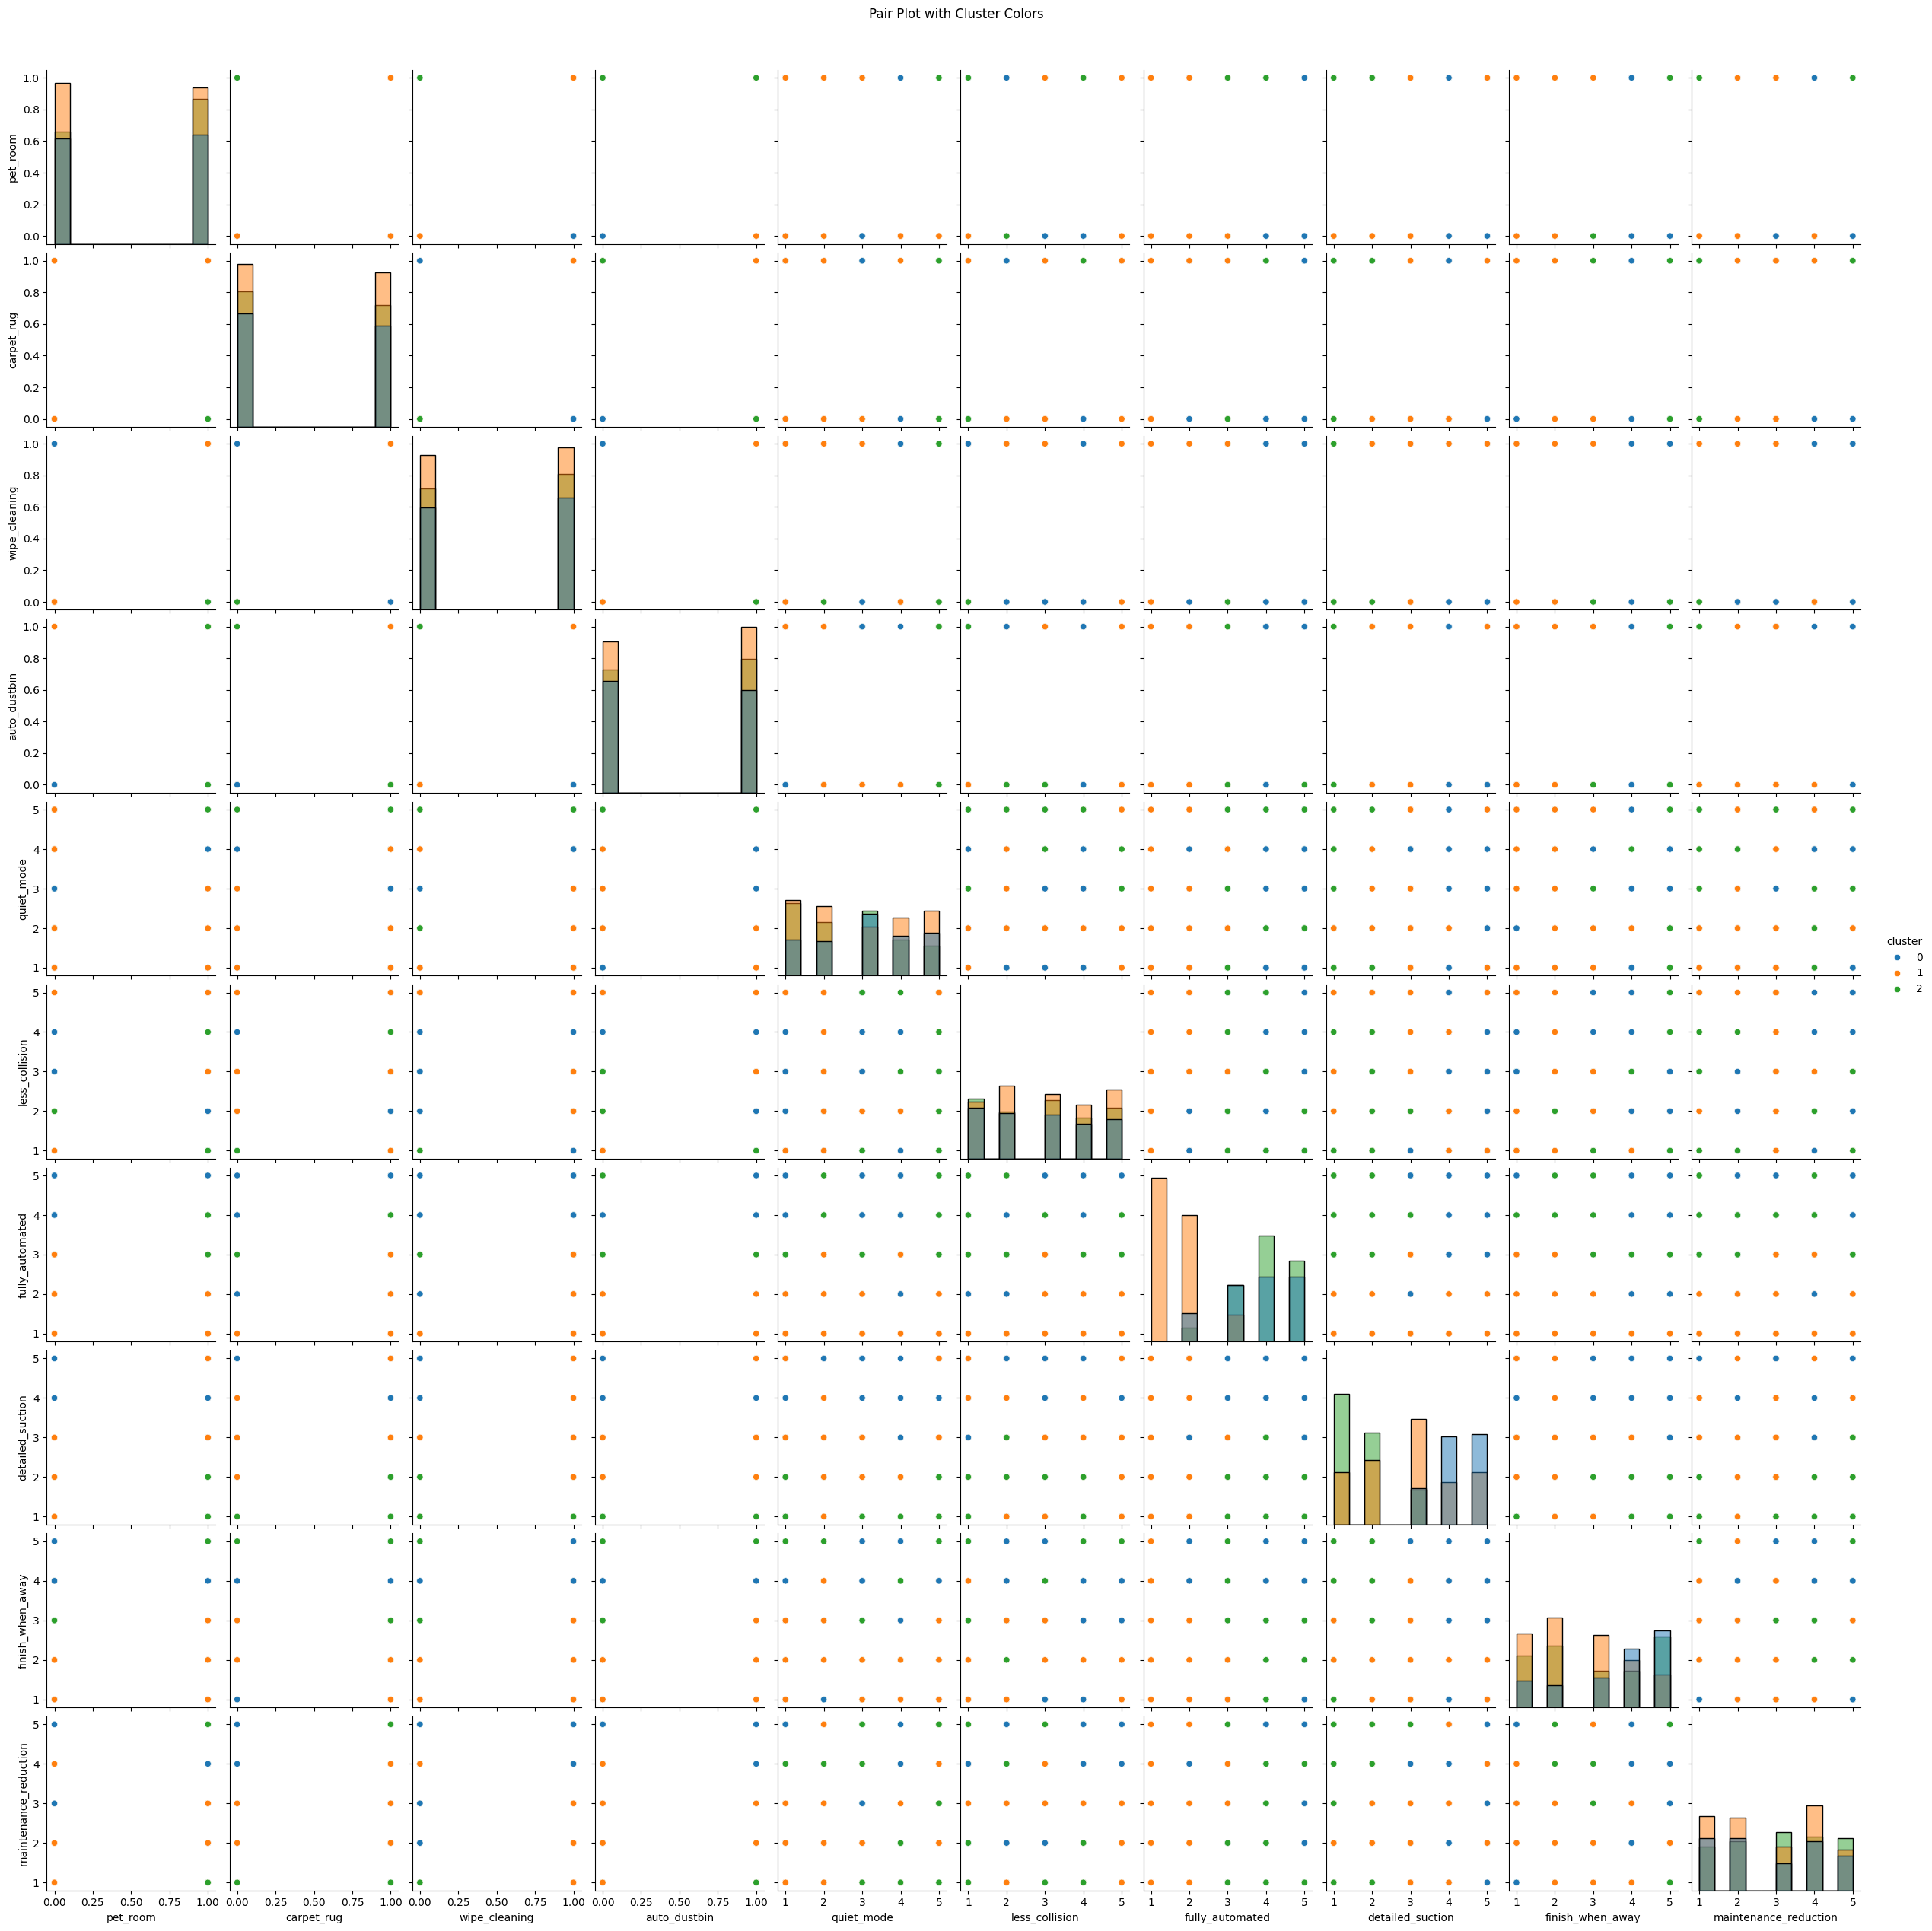

In [92]:
sns.pairplot(df_for_cluster, hue='cluster', diag_kind='hist')
plt.suptitle("Pair Plot with Cluster Colors", y=1.02)
plt.show()

平行座標プロットの作成（KMeansのクラスタごとに色分け）
どの質問がグループの違いに影響しているかを探る

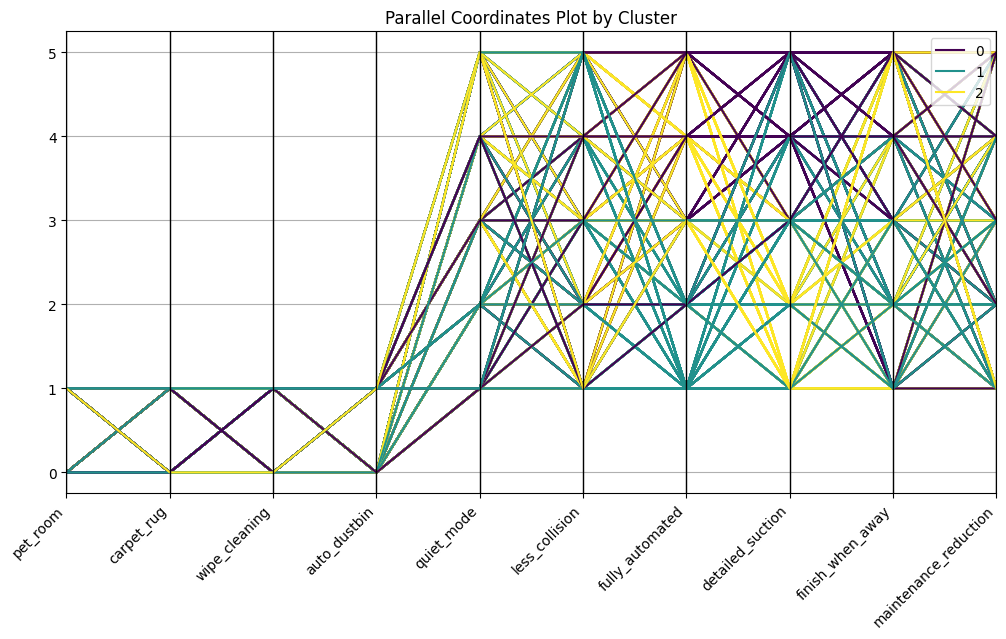

In [93]:
plt.figure(figsize=(12,6))
parallel_coordinates(df_for_cluster.reset_index(drop=True), class_column='cluster', colormap='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Parallel Coordinates Plot by Cluster")
plt.show()

MeanShift（教師なし学習）
クラスタリング数が1になってしまう。。。
現在のデータセットではMeanShiftによって適切なクラスタリングはできないかも

In [94]:
# バンド幅の推定
bandwidth = estimate_bandwidth(df_for_cluster, quantile=0.2, n_samples=500)
# クラスタリング実行
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(df_for_cluster)

labels_ms = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters_ms = len(np.unique(labels_ms))

print(f"MeanShiftの推定クラスタ数: {n_clusters_ms}")

# クラスタ結果をDataFrameに付与
# カラムcluster_msはMeanShiftの結果を反映
df_for_cluster["cluster_ms"] = labels_ms

print(df_for_cluster.head())

MeanShiftの推定クラスタ数: 1
   pet_room  carpet_rug  wipe_cleaning  auto_dustbin  quiet_mode  \
0       0.0         1.0            1.0           0.0         5.0   
1       0.0         0.0            1.0           0.0         5.0   
2       0.0         1.0            1.0           0.0         3.0   
3       1.0         1.0            1.0           1.0         1.0   
4       1.0         0.0            0.0           0.0         2.0   

   less_collision  fully_automated  detailed_suction  finish_when_away  \
0             5.0              2.0               5.0               4.0   
1             1.0              2.0               4.0               5.0   
2             5.0              3.0               3.0               2.0   
3             3.0              1.0               3.0               1.0   
4             1.0              3.0               3.0               5.0   

   maintenance_reduction cluster  cluster_ms  
0                    5.0       0           0  
1                    5.0       

BayesianGaussianMixture (VBGMM)（教師なし学習）

In [95]:
# n_componentsは最大クラスタ数の上限。これを変えるとクラスタ数が変化する
# クラスタ数を可変にするための変数を用意
n_clusters = 3
bgmm = BayesianGaussianMixture(n_components=n_clusters, random_state=42)  
bgmm.fit(df_for_cluster.drop(columns=["cluster_ms"], errors="ignore"))    # すでにcluster_msを付与している場合は除外
labels_bgmm = bgmm.predict(df_for_cluster.drop(columns=["cluster_ms"], errors="ignore"))

df_for_cluster["cluster_bgmm"] = labels_bgmm

#  n_clustersに合わせて自動でカラーパレットを生成
palette = sns.color_palette("Set2", n_clusters)

可視化（例: PCAで2次元に圧縮して散布図）
MeanShiftと VBGMMの結果をそれぞれ表示

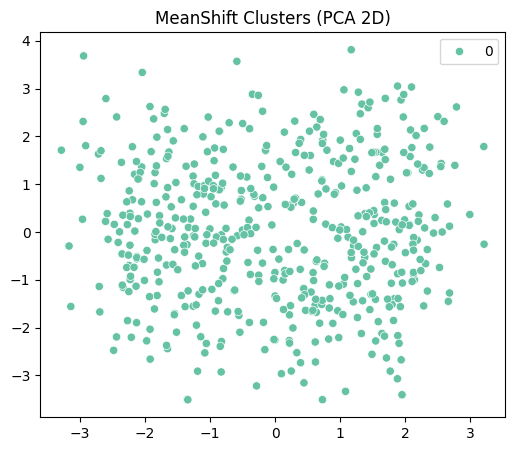

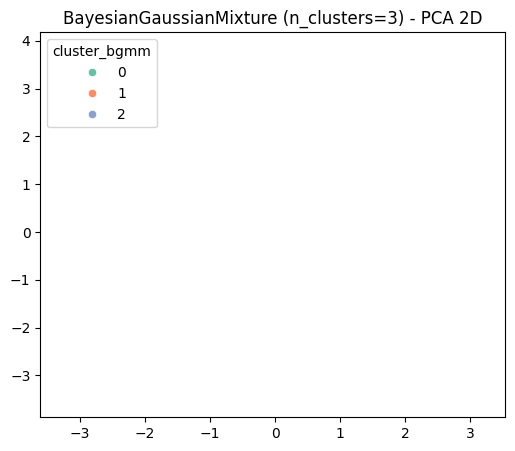

In [96]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_for_cluster.drop(columns=["cluster_ms","cluster_bgmm"], errors="ignore"))

# MeanShiftの結果を色分け表示
plt.figure(figsize=(6,5))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=labels_ms, palette="Set2")
plt.title("MeanShift Clusters (PCA 2D)")
plt.legend()
plt.show()

# VBGMMの結果を色分け表示
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=pca_result[:,0], 
    y=pca_result[:,1], 
    hue=df_for_cluster["cluster_bgmm"], 
    palette=palette,
    hue_order=[str(i) for i in range(n_clusters)]  # 0,1,2,... の順序を固定
)
plt.title(f"BayesianGaussianMixture (n_clusters={n_clusters}) - PCA 2D")
plt.show()

VBGMMの結果から並行座標プロットを作成してみる。
VBGMMのクラスタ数を変更すると描画が変わる

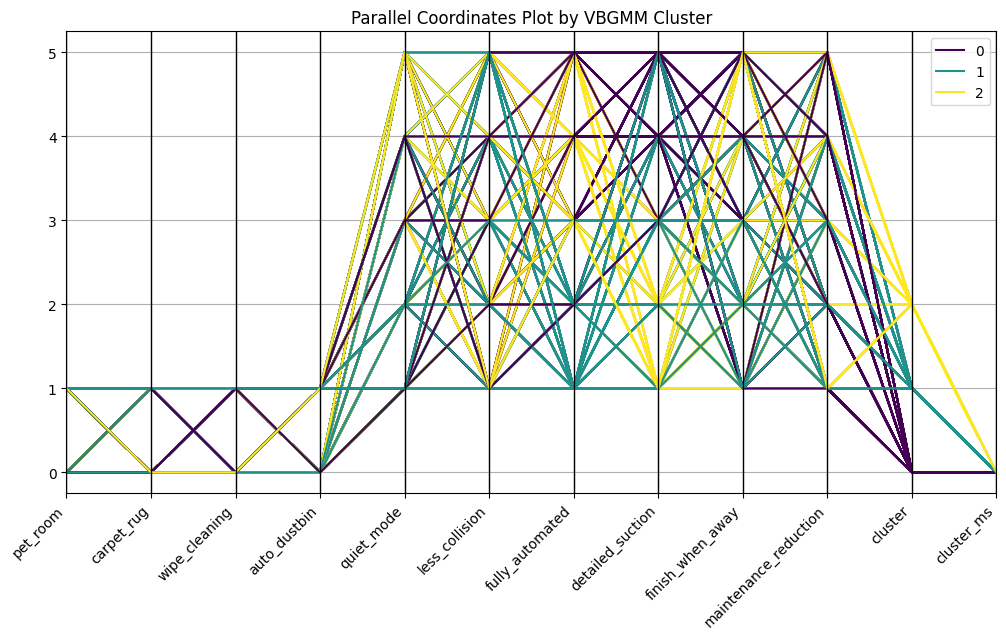

In [98]:
#   - class_column='cluster_bgmm' でクラスタラベルを色分け
#   - reset_index(drop=True) でインデックスを連番にリセット（描画上の不要な混乱を避ける）
plt.figure(figsize=(12,6))
parallel_coordinates(df_for_cluster.reset_index(drop=True),
                     class_column='cluster_bgmm',
                     colormap='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Parallel Coordinates Plot by VBGMM Cluster")
plt.show()